In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.utils.data.dataset as dataset
import numpy as np

from dataset import TestDataset
from model import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Extract features if you're using a newly trained model

In [3]:
# Load trained model
net = initialize_model2()
n_features = 512

SAVED_MODEL_PATH = 'checkpoints/vgg11bn_2_4'
net.load_state_dict(torch.load(SAVED_MODEL_PATH))

# Freeze layers
for param in net.parameters():
    param.requires_grad = False
    
# We just want to apply the feature extractor for now
net.classifier = nn.Identity()

In [4]:
# Get dataset
DATA_FILE = 'E:/xplore_data/data/images.h5'
HEALTH_FILE = 'data/dhs_gps.csv'
dimages = TestDataset(DATA_FILE, HEALTH_FILE)
dimagesloader = torch.utils.data.DataLoader(dimages, batch_size=64, shuffle=False, num_workers=0)

In [5]:
# Apply feature extractor to the dataset
n = len(dimages)
extracted_features = torch.zeros(n, n_features+11+1)
i = 0
# Iterate over data.
net.to(device)
for x, _, z in dimagesloader:
    x = x.to(device)
    j = i + x.shape[0]
    with torch.set_grad_enabled(False):
        outputs = net(x)
        extracted_features[i:j, :n_features] = torch.squeeze(outputs).cpu()
        extracted_features[i:j, n_features:n_features+11] = z[:, 14:25]
        extracted_features[i:j, n_features+11] = z[:, 3:14].mean(axis=1)
    i += 64

KeyboardInterrupt: 

In [6]:
torch.isnan(extracted_features).nonzero()

tensor([], size=(0, 2), dtype=torch.int64)

In [103]:
torch.save(extracted_features, 'data/features_vgg11bn_2_4.pt')

## Load pre-extracted features if you don't want to re-extract

In [6]:
extracted_features = torch.load('data/features_vgg11bn_2_4.pt')

In [7]:
dfeatures = dataset.TensorDataset(extracted_features)
n = extracted_features.shape[0]
n_features = 512

# Randomly split this dataset into train and test.
dtrain, dtest = dataset.random_split(dfeatures, (n - (n//5), n//5))

In [8]:
print(dfeatures.__getitem__(0)[0].shape)

torch.Size([524])


In [9]:
# Train the predictor model
def train_model(model, dataloader, optimizer, scheduler, num_epochs=4, test_loader=None, tgt=3):
    print_every = 100
    for epoch in range(num_epochs+1):
        if epoch % print_every == 0:
            print('Epoch {}/{}: '.format(epoch, num_epochs), end='')

        model.train()
        running_loss = 0.0
        criterion = nn.BCEWithLogitsLoss(reduction='none')
#         criterion = nn.MSELoss(reduction='none')

        # Iterate over data.
        for rows in dataloader:
            x = rows[0][:, :n_features].to(device)
            y = rows[0][:, n_features+tgt].to(device)
#             y = rows[0][:, n_features:n_features+11].to(device)
#             wt = rows[0][:, n_features+11].to(device)
#             wt = wt / wt.sum() * x.shape[0] #give the weights an avg of 1
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(x).squeeze()
#                 print(outputs.shape)
#                 print(y.shape)
#                 loss = torch.sum(criterion(outputs, y).mean(axis=1) * wt)
                loss = torch.mean(criterion(outputs, y))
                loss.backward()
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

            # statistics
            running_loss += loss.item() * x.size(0)

        epoch_loss = running_loss / len(dtrain)
        if epoch % print_every == 0:
            print('Training loss: {:.4f}; '.format(epoch_loss), end='')
        test_loss = 0.0
        
        if test_loader is not None:
            for rows in test_loader:
                x = rows[0][:, :n_features].to(device)
                y = rows[0][:, n_features+tgt].to(device)
#                 y = rows[0][:, n_features:n_features+11].to(device)
#             wt = rows[0][:, n_features+11].to(device)
#             wt = wt / wt.sum()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(False):
                    outputs = model(x).squeeze()
#                 loss = torch.sum(criterion(outputs, y).mean(axis=1) * wt)
                    loss = torch.mean(criterion(outputs, y))

                # statistics
                test_loss += loss.item() * x.size(0)
        test_loss /= len(dtest)
        if epoch % print_every == 0:
            print('Test loss: {:.4f}'.format(test_loss))

    return model


In [10]:
# Simple neural network to predict healthcare
def initialize_predictor():
    predictor = nn.Sequential(
        nn.Linear(n_features, 50),
        nn.Sigmoid(),
        nn.Linear(50, 20),
        nn.Sigmoid(),
        nn.Linear(20, 1)
    )
#     predictor = nn.Sequential(
#         nn.Linear(n_features, 10),
#         nn.Sigmoid(),
#         nn.Linear(10, 1)
#     )
    predictor.to(device)
    return predictor

In [34]:
BATCH_SIZE = (889+3)//4
EPOCHS = 500

predictor = initialize_predictor()
tgt = 9

# Data loader
dloader = torch.utils.data.DataLoader(dtrain, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dtestloader = torch.utils.data.DataLoader(dtest, batch_size=512, shuffle=False, num_workers=0)

# Create training optimizer
optimizer = optim.Adam(predictor.parameters(), lr=0.01, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)


In [38]:
predictor = train_model(predictor, dloader, optimizer, scheduler, 
                        num_epochs=EPOCHS, test_loader=dtestloader,
                        tgt=tgt)

Epoch 0/500: Training loss: 0.4614; Test loss: 0.5384
Epoch 100/500: Training loss: 0.4614; Test loss: 0.5384
Epoch 200/500: Training loss: 0.4614; Test loss: 0.5383
Epoch 300/500: Training loss: 0.4614; Test loss: 0.5383
Epoch 400/500: Training loss: 0.4614; Test loss: 0.5383
Epoch 500/500: Training loss: 0.4614; Test loss: 0.5383


0.7051, 0.4365


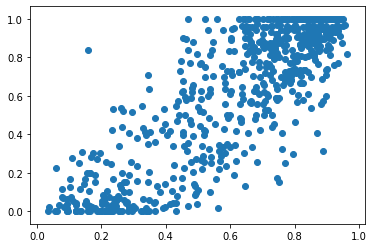

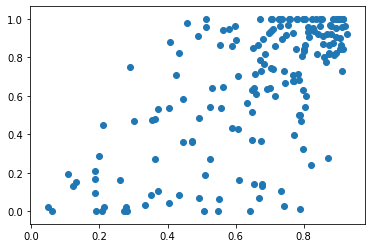

In [39]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

with torch.no_grad():
    split = [dtrain.indices, dtest.indices]
    tensor_inputs = [extracted_features[x, :n_features].to(device) for x in split]
    targets = [extracted_features[x, n_features+tgt].numpy() for x in split]
    preds = [torch.sigmoid(predictor(x)).cpu().numpy() for x in tensor_inputs]
r2s = [r2_score(y, pred) for y, pred in zip(targets, preds)]
print('%.4f, %.4f' % tuple(r2s))

plt.scatter(preds[0], targets[0])
plt.show()
plt.scatter(preds[1], targets[1])
plt.show()

## Put together the end-to-end network and save it

In [37]:
import os
net.classifier = predictor
checkpoint_name = 'vgg11bn_2_e2e_' + str(tgt)
CHECKPOINT_FOLDER = 'checkpoints/'
torch.save(net.state_dict(), os.path.join(CHECKPOINT_FOLDER, checkpoint_name))

In [16]:
net

VGG(
  (features): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke